# MaxFuse integration of Merfish and scRAseq data.

In [27]:
%pip install anndata
%pip install scanpy
%pip install maxfuse

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


This analysis is based on the MaxFuse vignette tonsil_merfish_rnaseq tutorial. It uses MerFish data from ... and scRNAseq data from ...


In [28]:
import glob
import numpy as np
import pandas as pd
from scipy.io import mmread

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc
import maxfuse as mf

import seaborn as sns

## Data acquire

Start the development on files from one specimen. Expand later to entire dataset. The file format for MaxFuse to read in is ```adata```. 

In [30]:
merfish_data_path = '../project-files/'
scRNAseq_data_path = '../project-files/filtered_scRNA-seq/'
#define dataset by HTAN identifier
dataset_index = 8
HTAN_IDs = ['HTAPP-982','HTAPP-944','HTAPP-917','HTAPP-880','HTAPP-878','HTAPP-853','HTAPP-812','HTAPP-514','HTAPP-313']
#get merfish filenames
filename = glob.glob(merfish_data_path+HTAN_IDs[dataset_index]+'_centroids*')[0]
merfish_ad = ad.read_h5ad(filename)
merfish_ad.obs['data_type'] = 'merfish'
merfish_ad.obs['celltype'] = merfish_ad.obs.cell_type

filename = glob.glob(scRNAseq_data_path+HTAN_IDs[dataset_index]+'*1*')[0]
scrna_ad = ad.read_h5ad(filename)
scrna_ad.obs['data_type'] = 'scRNA'

/opt/conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Data preprocessing

**Optional**: meta data for the cells. In this case we are using them to **evaluate the integration results**, but for actual running, MaxFuse does not require you have this information.

In [31]:
scrna_ad.obs

,cell_groups,data_type
AAACCCAAGATGCGAC-1,MBC,scRNA
AAACCCAAGCACACAG-1,MBC,scRNA
AAACCCAGTATGGTAA-1,B_plasma,scRNA
AAACCCAGTGGATACG-1,MBC,scRNA
AAACCCAGTTATCCAG-1,T,scRNA
...,...,...
TTTGGTTTCTCCGAAA-1,Monocyte,scRNA
TTTGGTTTCTGGTGGC-1,MBC,scRNA
TTTGTTGAGATCCCAT-1,MBC,scRNA
TTTGTTGAGGACAAGA-1,MBC,scRNA


In [32]:
# rename cell groups to celltype in case MaxFuse uses that name internally, this is unlikely
scrna_ad.obs['celltype'] = scrna_ad.obs.cell_groups

#remove duplicated columns, wouyld be best to keep one of them
seen = set()
dupes = []
for x in scrna_ad.var_names:
    if x in seen:
        dupes.append(x)
    else:
        seen.add(x)
unique_mask = ~np.isin(scrna_ad.var_names, dupes)
scrna_ad = scrna_ad[:,unique_mask]


Here we are integrating spatial Merfish data and RNA data, and most of the time the genes names should be the same.

These "weak linked" features will be used during initialization (we construct two arrays, `rna_shared` and `merfish_shared`, whose columns are matched, and the two arrays can be used to obtain the initial matching). 


In [33]:
# Columns scrna_shared and merfish_shared are matched.
shared = list(set(scrna_ad.var_names).intersection(set(merfish_ad.var_names)))
scrna_shared_ad = scrna_ad[:, shared].copy()
merfish_shared_ad = merfish_ad[:, shared].copy()

Then we retrieve the shared features. Normally we should not use all the shared featues, as some of the shared feature RNA are not very variable, and inputing low quality features could potentially decrease the performance of ```MaxFuse```. In this case we only use features that are variable (larger than a certain threshold).

In [34]:
# Make sure no column is static
mask = (
    (scrna_shared_ad.X.toarray().std(axis=0) > 0.5) 
    & (merfish_shared_ad.X.std(axis=0) > 0.1)
)
scrna_shared_ad = scrna_shared_ad[:, mask].copy()
merfish_shared_ad = merfish_shared_ad[:, mask].copy()
print([scrna_shared_ad.shape,merfish_shared_ad.shape])

[(6306, 174), (11441, 174)]


We skipped the processing steps for both datasets because the input data was already normalized.

In [38]:
# process scrna_shared_ad
sc.pp.normalize_total(scrna_shared_ad)
sc.pp.log1p(scrna_shared_ad)
sc.pp.scale(scrna_shared_ad)


/opt/conda/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/opt/conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:351: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


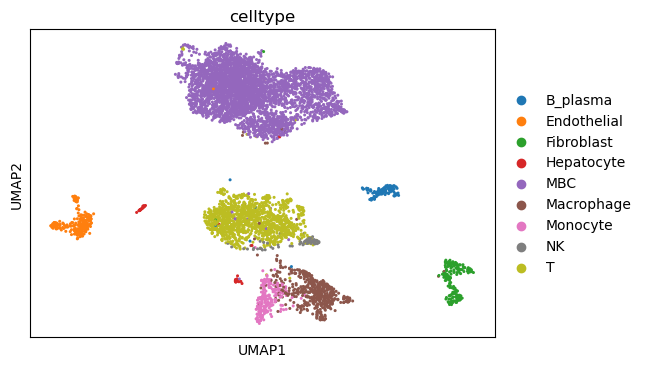

In [39]:
# plot UMAP of scrna cells based only on scrna markers with merfish correspondence
sc.pp.neighbors(scrna_shared_ad, n_neighbors=15)
sc.tl.umap(scrna_shared_ad)
sc.pl.umap(scrna_shared_ad, color='celltype')

/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


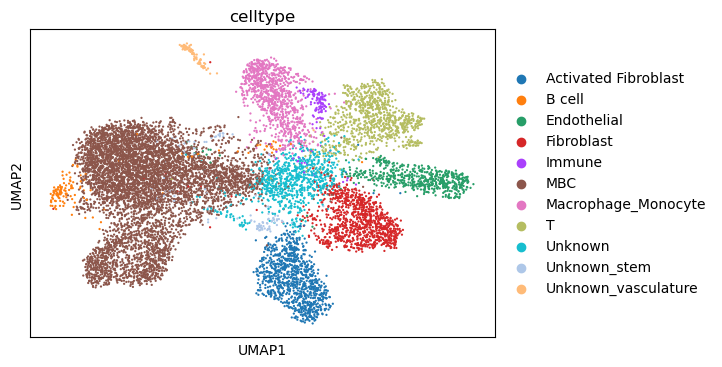

In [40]:
# plot UMAPs of merfish cells based only on markers with scrna correspondence
sc.pp.neighbors(merfish_shared_ad, n_neighbors=15)
sc.tl.leiden(merfish_shared_ad)
sc.tl.umap(merfish_shared_ad)
sc.pl.umap(merfish_shared_ad, color = 'celltype')


In [41]:
scrna_shared = scrna_shared_ad.X.copy()
merfish_shared = merfish_shared_ad.X.copy()

We again apply standard Scanpy preprocessing steps to **all available RNA measurements and merfish measurements** (not just the shared ones) to get two arrays, `scrna_active` and `merfish_active`, which are used for iterative refinement. Again if the input data is already processed, these steps can be skipped.

In [42]:
# process all RNA features
sc.pp.normalize_total(scrna_ad)
sc.pp.log1p(scrna_ad)
sc.pp.highly_variable_genes(scrna_ad, n_top_genes=5000)
# only retain highly variable genes
scrna_ad = scrna_ad[:, scrna_ad.var.highly_variable].copy()
sc.pp.scale(scrna_ad)

/opt/conda/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


         Falling back to preprocessing with `sc.pp.pca` and default params.


/opt/conda/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


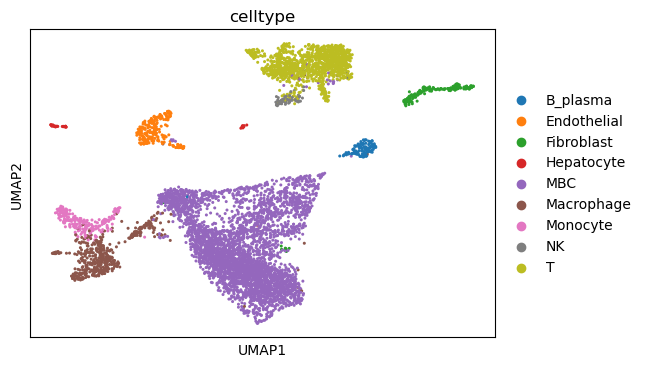

In [43]:
# plot UMAPs of scrna cells based on all active rna markers

sc.pp.neighbors(scrna_ad, n_neighbors=15)
sc.tl.umap(scrna_ad)
sc.pl.umap(scrna_ad, color='celltype')

/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


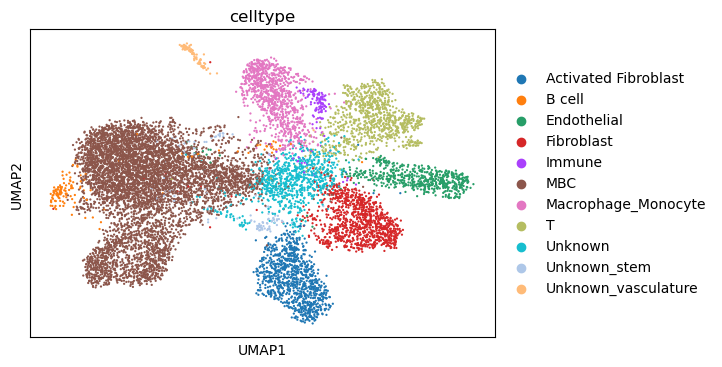

In [44]:
# plot UMAPs of merfish cells based on all active genes
sc.pp.neighbors(merfish_ad, n_neighbors=15)
sc.tl.leiden(merfish_ad)
sc.tl.umap(merfish_ad)
sc.pl.umap(merfish_ad, color='celltype')

In [45]:
# make sure no feature is static
scrna_active = scrna_ad.X
merfish_active = merfish_ad.X
scrna_active = scrna_active[:, scrna_active.std(axis=0) > 1e-5] 
merfish_active = merfish_active[:, merfish_active.std(axis=0) > 1e-5] 

In [46]:
# inspect shape of the four matrices
print(scrna_active.shape)
print(merfish_active.shape)
print(scrna_shared.shape)
print(merfish_shared.shape)

(6306, 5000)
(11441, 291)
(6306, 174)
(11441, 174)


## Fitting MaxFuse

### Step I: preparations

We now have four arrays. `rna_shared` and `merfish_shared` are used for finding initial pivots, whereas `rna_active` and `merfish_active` are used for iterative refinement. 

The main object for running MaxFuse pipeline is `mf.model.Fusor`, and its constructor takes the above four arrays as input.

If your data have not been clustered and annotated, you can leave `labels1` and `labels2` to be `None`, then MaxFuse will automatically run clustering algorithms to fill them in.

**Optional**: If your data have already been clustered (and you trust your annotation is optimal and should be used to guide the MaxFuse smoothing steps), you could supply them as ```numpy``` arrays to `labels1` and `labels2`.

In [47]:
# call constructor for Fusor object
# which is the main object for running MaxFuse pipeline
fusor = mf.model.Fusor(
    shared_arr1=scrna_shared,
    shared_arr2=merfish_shared,
    active_arr1=scrna_active,
    active_arr2=merfish_active,
    labels1=None,
    labels2=None
)

To reduce computational complexity, we call `split_into_batches` to fit the batched version of MaxFuse.

Internally, MaxFuse will solve a few linear assignment problems of size $n_1 \times n_2$, where $n_1$ and $n_2$ (with $n_1\leq n_2$ by convention) are the sample sizes of the two modalities (after batching and metacell construction).
`max_outward_size` specifis the maximum value of $n_1$.

`matching_ratio` specifies approximately the ratio of $n_2/n_1$.
The larger it is, the more candidate cells in the second modality MaxFuse will seek for to match each cell/metacell in the first modality.

`metacell_size` specifies the average size of the metacells in the first modality.

Since this integration process is larger (more merfish cells), we could increase the `max_outward_size` as long as the memory can accomodate that.

In [48]:
fusor.split_into_batches(
    max_outward_size=3000,
    matching_ratio=4,
    metacell_size=2,
    verbose=True
)

The first data is split into 1 batches, average batch size is 6306, and max batch size is 6306.
The second data is split into 1 batches, average batch size is 11441, and max batch size is 11441.
Batch to batch correspondence is:
  ['0<->0'].


The next step is to construct appropriate nearest-neighbor graphs for each modality with all features available.
But before that, we plot the singular values of the two active arrays to determine how many principal components (PCs) to keep when doing graph construction.

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

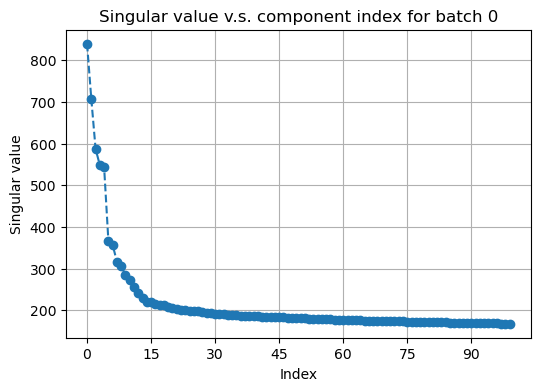

In [49]:
# plot top singular values of avtive_arr1 on a random batch
fusor.plot_singular_values(
    target='active_arr1',
    n_components=None # can also explicitly specify the number of components
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

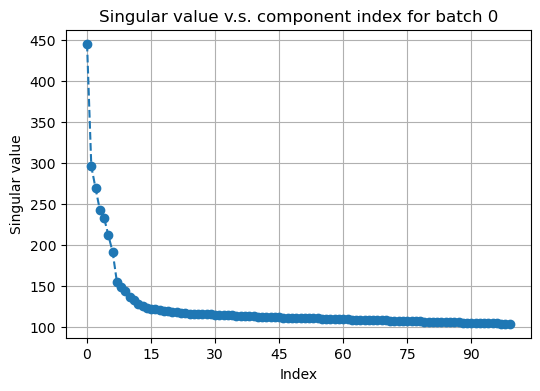

In [50]:
# plot top singular values of avtive_arr2 on a random batch
fusor.plot_singular_values(
    target='active_arr2',
    n_components=None
)

Inspecting the "elbows", we choose the number of PCs to be **40** for both RNA and  **15** for protein active data.
We then call `construct_graphs` to compute nearest-neighbor graphs as needed.

In [ ]:
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=30,
    svd_components2=30,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...


/opt/conda/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...


/opt/conda/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...


### Step II: finding initial pivots

We then use shared arrays whose columns are matched to find initial pivots.
Before we do so, we plot top singular values of two shared arrays to determine how many PCs to use.

In [ ]:
# plot top singular values of shared_arr1 on a random batch
fusor.plot_singular_values(
    target='shared_arr1',
    n_components=None,
)

In [ ]:
# plot top singular values of shared_arr2 on a random batch
fusor.plot_singular_values(
    target='shared_arr2',
    n_components=None
)

We choose to use **40** PCs for ``scrna_shared`` and **27** PCs for ``merfish_shared``.

We then call ``find_initial_pivots`` to compute initial set of matched pairs.
In this function, ``wt1`` (resp. ``wt2``) is a number between zero and one that specifies the weight on the smoothing target for the first (resp. second) modality. 
The smaller it is, the greater the strength of fuzzy smoothing.
When the weight is one, then there is no smoothing at all, meaning the original data will be used.


In [ ]:
fusor.find_initial_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=40, svd_components2=27
)

Now, we have a set of *initial pivots* that store the matched pairs when only the information in the shared arrays is used. The information on initial pivots are stored in the internal field ``fusor._init_matching`` that is invisible to users.

### Step III: finding refined pivots

We now use the information in active arrays to iteratively refine initial pivots.
We plot the top canonical correlations to choose the best number of components in canonical correlation analysis (CCA).

In [ ]:
# plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=50,
    svd_components2=None,
    cca_components=45
)

A quick check on the previous plot gives a rough guide on what the `refine_pivots` parameters should be picked.

**Note:** here that the `n_iters` number we choosed *1*, as in low snr datasets (eg. Spatial-omis) increase amount of iteration might degrade the performance.

In [21]:
fusor.refine_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=40, svd_components2=None,
    cca_components=15,
    n_iters=1,
    randomized_svd=False, 
    svd_runs=1,
    verbose=True
)

NameError: name 'fusor' is not defined

**Note:** here we can see `filter_prop` we increased the pivot filtering to *0.5* compared to previous example. We found harsher filtering for integrations that involves spatial-omics is more beneficial.

In [26]:
fusor.filter_bad_matches(target='pivot', filter_prop=0.5)

Begin filtering...
Now at batch 0<->0...
1577/3153 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
3206/6306 cells in arr1 are selected as pivots.
1577/11441 cells in arr2 are selected as pivots.
Done!


**Optional:** quick check the performance based on cell type accuracy (pivot matching).

In [27]:
pivot_matching = fusor.get_matching(order=(2, 1),target='pivot')
labels_scrna = scrna_ad.obs.celltype
labels_merfish = merfish_ad.obs.celltype
x_centroids_merfish = merfish_ad.obs.x_centroid
y_centroids_merfish = merfish_ad.obs.y_centroid

lv1_acc = mf.metrics.get_matching_acc(matching=pivot_matching, 
    labels1=labels_scrna, 
    labels2=labels_merfish,
    order = (2,1)
)
lv1_acc

/opt/conda/lib/python3.11/site-packages/maxfuse/metrics.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(rows, cols)])


0.7209892200380469

In [18]:
# We can inspect the first pivot pair.
[pivot_matching[0][0], pivot_matching[1][0], pivot_matching[2][0]]

NameError: name 'pivot_matching' is not defined

**Note:** Since we have the `refine_pivots` now, we can theoratically co-embedding the *full* dataset into CCA space (as described in `tutorial-1`). **However**, in the case that invovles *low-snr* datasets (eg. spatial-omics), we do not suggest projecting all the cells into a common space without any filtering steps. We will describe this process after the `propogation` step.

### Step IV: propagation

Refined pivots can only give us a pivot matching that captures a subset of cells. In order to get a *full* matching that involves all cells during input, we need to call `propagate`.


In [ ]:
fusor.propagate(
    svd_components1=40, 
    svd_components2=None, 
    wt1=0.7,
    wt2=0.7,
)

We call `filter_bad_matches` with `target=propagated` to optionally filter away a few matched pairs from propagation. 

**Note:** In the best scenario, we would prefer all cells in the *full* dataset can be matched accross modality. However, in the case that invovles *low-snr* datasets (eg. spatial-omics), many cells are noisy (or lack of information) and should not be included in downstream cross-modality analysis. We suggest in such scenarios, `filter_prop` should be set around *0.1-0.4*.

In [20]:
fusor.filter_bad_matches(
    target='propagated',
    filter_prop=0.3
)

NameError: name 'fusor' is not defined

We use `get_matching` with `target='full_data'` to extract the full matching.

Because of the batching operation, the resulting matching may contain duplicates. The `order` argument determines how those duplicates are dealt with. 
`order=None` means doing nothing and returning the matching with potential duplicates;
`order=(1, 2)` means returning a matching where each cell in the first modality contains *at least one match* in the second modality;
`order=(2, 1)` means returning a matching where each cell in the second modality contains *at least one match* in the first modality.

**Note:** Since we filtered out some cell pairs here, not all cells in the full dataset has matches.

In [ ]:
full_matching = fusor.get_matching(order=(2, 1), target='full_data')

In [19]:
full_matching

NameError: name 'full_matching' is not defined

Since we are doing `order=(2, 1)` here, the matching info is all the cells (10k) in mod 2 (protein) has at least one match cell in the RNA modality. Note that the matched cell in RNA could be duplicated, as protein cells could be matched to the same RNA cell. For a quick check on matching format:

In [32]:
pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])), 
             columns = ['mod1_indx', 'mod2_indx', 'score'])
# columns: cell idx in mod1, cell idx in mod2, and matching scores

,mod1_indx,mod2_indx,score
0,5283,2,0.966548
1,4501,13,0.960284
2,1498,21,0.953177
3,2299,24,0.925278
4,5831,31,0.894419
...,...,...,...
8156,2496,11434,0.072970
8157,3497,11437,0.764328
8158,2403,11438,0.450143
8159,3702,11439,0.804316


# compute the cell type level matching accuracy, for the full (filtered version) dataset
lv1_acc = mf.metrics.get_matching_acc(matching=full_matching, 
    labels1=labels_rna, 
    labels2=labels_merfish 
)
lv1_acc

### Step V: downstream analysis

As mentioned before, we want to draw a UMAP in the joint-embedding space, but for the filtered version of cells. For the *low-snr* datasets (eg. spatial-omics), we suggest only using cells that survived the propogation filtering step.

In [33]:
scrna_cca, merfish_cca = fusor.get_embedding(
    active_arr1=fusor.active_arr1,
    active_arr2=fusor.active_arr2[full_matching[1],:] # cells in merfish remained after filtering
)

In [34]:
dim_use = 15 # dimensions of the CCA embedding to be used for UMAP etc

cca_adata = ad.AnnData(
    np.concatenate((scrna_cca[:,:dim_use], merfish_cca[:,:dim_use]), axis=0), 
    dtype=np.float32
)
cca_adata.obs['data_type'] = ['scrna'] * scrna_cca.shape[0] + ['merfish'] * merfish_cca.shape[0]
cca_adata.obs['cell_type'] = list(np.concatenate((labels_scrna,
                                                  labels_merfish[full_matching[1]]), axis = 0))
cca_adata.obs['x_centroids'] = list(np.concatenate(([0] * scrna_cca.shape[0],
                                                  x_centroids_merfish[full_matching[1]]), axis = 0))
cca_adata.obs['y_centroids'] = list(np.concatenate(([0] * scrna_cca.shape[0],
                                                  y_centroids_merfish[full_matching[1]]), axis = 0))

/opt/conda/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/tmp/ipykernel_844/3346720718.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels_merfish[full_matching[1]]), axis = 0))
/tmp/ipykernel_844/3346720718.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_centroids_merfish[full_matching[1]]), axis = 0))
/tmp/ipykernel_844/3346720718.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent w

/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


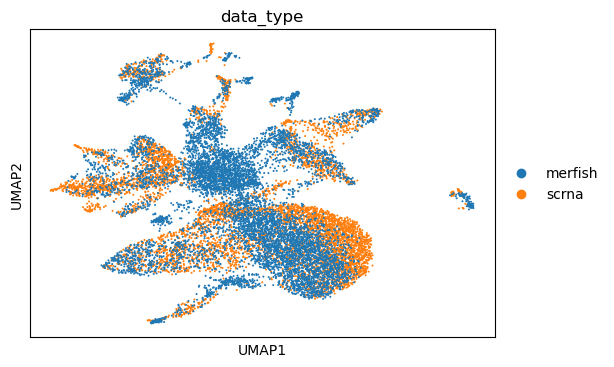

In [35]:
sc.pp.neighbors(cca_adata, n_neighbors=15)
sc.tl.umap(cca_adata)
sc.pl.umap(cca_adata, color='data_type', save='_MaxFuse_data_type.png')

/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


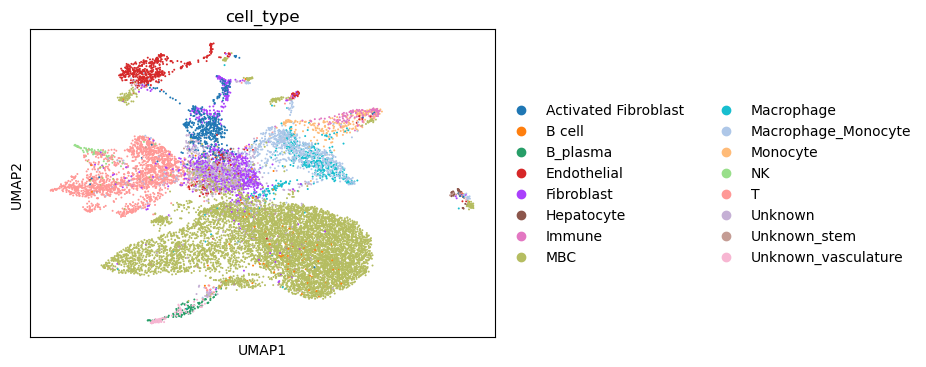

In [36]:
sc.pl.umap(cca_adata, color='cell_type', save='_MaxFuse_cell_type.png')

In [37]:
#combine the initial data and create a UMAP of it not integrated
merfish_scrna_ad = ad.concat([merfish_shared_ad, scrna_shared_ad])

/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


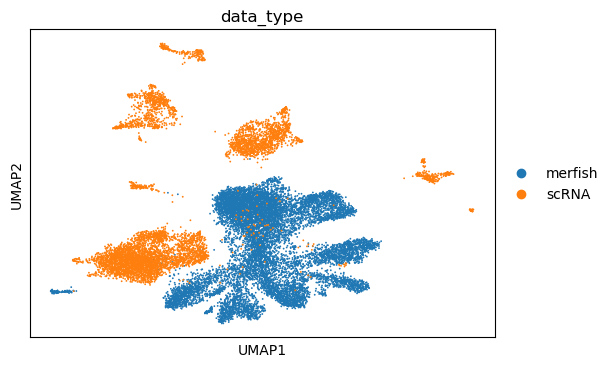

/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


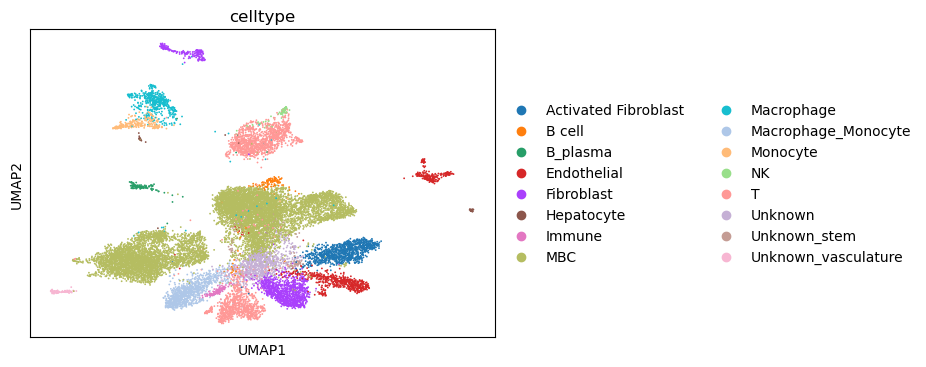

In [38]:
sc.pp.neighbors(merfish_scrna_ad, n_neighbors=15)
sc.tl.umap(merfish_scrna_ad)
sc.pl.umap(merfish_scrna_ad, color='data_type', save='_no_integration_data_type.png')
sc.pl.umap(merfish_scrna_ad, color='celltype', save='_no_integration_cell_type.png')

In [39]:
#write integrated h4ad file
integrated_data_path = '../project-files/integrated_data/'
temp_output_path = '/sbgenomics/output-files/'
cca_adata.write_h5ad(temp_output_path+HTAN_IDs[dataset_index]+'_MaxFuse.h5ad')